In [1]:
import pandas as pd
import numpy as np

In [2]:
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

fake['target'] = 0
true['target'] = 1

In [3]:
fake.shape

(23481, 5)

In [4]:
true.shape

(21417, 5)

In [5]:
news = pd.concat([true, fake], ignore_index = True)
news['text'] = news['title'] + " " + news['text']
news.shape

(44898, 5)

In [6]:
news[21416:21420]

,title,text,subject,date,target
21416,Indonesia to buy $1.14 billion worth of Russia...,Indonesia to buy $1.14 billion worth of Russia...,worldnews,"August 22, 2017",1
21417,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",0
21418,Drunk Bragging Trump Staffer Started Russian ...,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",0
21419,Sheriff David Clarke Becomes An Internet Joke...,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",0


In [7]:
news['text'].head(20)

0     As U.S. budget fight looms, Republicans flip t...
1     U.S. military to accept transgender recruits o...
2     Senior U.S. Republican senator: 'Let Mr. Muell...
3     FBI Russia probe helped by Australian diplomat...
4     Trump wants Postal Service to charge 'much mor...
5     White House, Congress prepare for talks on spe...
6     Trump says Russia probe will be fair, but time...
7     Factbox: Trump on Twitter (Dec 29) - Approval ...
8     Trump on Twitter (Dec 28) - Global Warming The...
9     Alabama official to certify Senator-elect Jone...
10    Jones certified U.S. Senate winner despite Moo...
11    New York governor questions the constitutional...
12    Factbox: Trump on Twitter (Dec 28) - Vanity Fa...
13    Trump on Twitter (Dec 27) - Trump, Iraq, Syria...
14    Man says he delivered manure to Mnuchin to pro...
15    Virginia officials postpone lottery drawing to...
16    U.S. lawmakers question businessman at 2016 Tr...
17    Trump on Twitter (Dec 26) - Hillary Clinto

In [8]:
import re
import nltk
from nltk.corpus import stopwords
import string
from string import punctuation

stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuation)

def preprocess_text(df):
    df['text'] = df['text'].str.replace('\[[^]]*\]', '')
    df['text'] = df['text'].apply(lambda x : x.lower())
    df['text'] = df['text'].apply(lambda x : x.split(" "))
    df['text'] = df['text'].apply(lambda x : [word for word in x if word not in stop])
    df['text'] = df['text'].apply(lambda x : " ".join(x))
    df['text'] = df['text'].str.replace('https?:\/\/.*[\r\n]*', '')
    df['text'] = df['text'].str.replace('[^\w\s]', '')
    
    return df

news = preprocess_text(news)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.


In [9]:
empty_text = [index for index,text in enumerate(news.text.values) if str(text).strip() == '']
len(empty_text)

9

In [10]:
news = news.drop(empty_text)
news = news.drop(['title'], axis = 1)
news.shape

(44889, 4)

In [11]:
news['text'].apply(lambda x : len(str(x).split())).max()

4974

Tokenizer fit_on_text first create word_index that maps each word in vocabulary to number of occurances. Then, it sorts this key-value pairs in descending order of values. Finally, it assigns every unique word an integer value from 1, 2, 3...

text_to_sequences transforms each text to a sequence of integers. 

In [12]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(news['text'])
News_seq = t.texts_to_sequences(news['text'])
# X_test_seq = t.texts_to_sequences(X_test)

In [13]:
len(t.word_index)

216766

In [14]:
from keras.preprocessing import sequence

News_pad = sequence.pad_sequences(News_seq, maxlen = 1000)
# X_test_pad = sequence.pad_sequences(X_test_seq, maxlen = 1000)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(News_pad, news['target'], test_size = 0.3, random_state = 2021, stratify = news['target'], shuffle = True)

In [16]:
def model():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(len(t.word_index) + 1, output_dim = 300, input_length = 1000 ))
    model.add(keras.layers.SimpleRNN(10))
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))
    return model

model = model()

2021-11-04 07:32:38.036328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 07:32:38.140920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 07:32:38.141843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-04 07:32:38.143090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 0.0001)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         65030100  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                3110      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 65,033,221
Trainable params: 65,033,221
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 128, validation_data = (X_test, y_test), callbacks = [lr_scheduler])

2021-11-04 07:32:40.933347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
246/246 [==============================] - 268s 1s/step - loss: 0.2487 - accuracy: 0.9524 - val_loss: 0.0940 - val_accuracy: 0.9851
Epoch 2/5
246/246 [==============================] - 268s 1s/step - loss: 0.0531 - accuracy: 0.9908 - val_loss: 0.0471 - val_accuracy: 0.9919
Epoch 3/5
246/246 [==============================] - 271s 1s/step - loss: 0.0410 - accuracy: 0.9895 - val_loss: 0.1031 - val_accuracy: 0.9682
Epoch 4/5
246/246 [==============================] - 271s 1s/step - loss: 0.0544 - accuracy: 0.9829 - val_loss: 0.0964 - val_accuracy: 0.9690
Epoch 5/5
246/246 [==============================] - 270s 1s/step - loss: 0.0206 - accuracy: 0.9962 - val_loss: 0.0743 - val_accuracy: 0.9788


In [19]:
from sklearn.metrics import roc_auc_score

pred_t = model.predict(X_test)
pred_t = pred_t.reshape(-1,)
print(roc_auc_score(y_test, pred_t))

0.9946895724043732


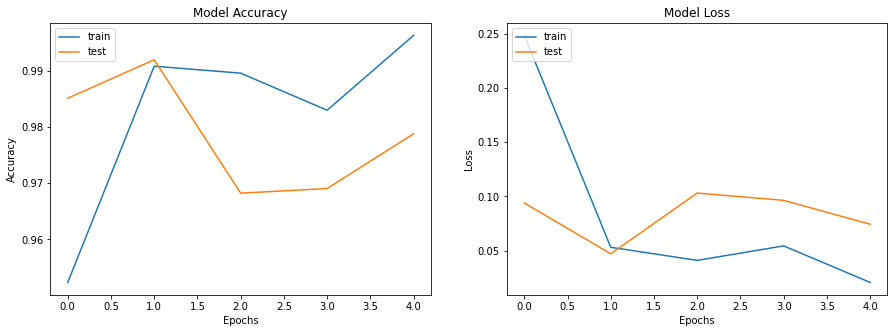

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc = 'upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc = 'upper left')

plt.show()

Reference notebooks :

https://www.kaggle.com/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

https://www.kaggle.com/josutk/only-one-word-99-2

https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy